## Notebook 2: Feature Engineering

The goal of this notebook is to generate a series of transformations to the original set of features $X_i$ that capture the main beahviours of the the target $y$. The philosophy of these transformations is heavily inspired by the Kaggle discussions and optimised by us for better results. 

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import holidays
import warnings
   
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from dataclasses import dataclass

warnings.simplefilter(action="ignore", category=FutureWarning)

In [28]:
# Load train and test data
train_df = pd.read_csv("data/train.csv")
train_df.date = pd.DatetimeIndex(train_df.date)

The train dataste is split $80\%$ for training and $20\%$ for testing. The rows for testing are marked in a binary identifier column `test`. This way, all the trasnformations made to the train dataset are also efficiently applied to the test data. 

In [29]:
# Load train data
df = pd.read_csv("data/train.csv")
df["date"] = pd.to_datetime(df["date"])

# Sort by date
df = df.sort_values(by="date")

# Calculate the split index
split_idx = int(len(df) * 0.8)

# Assign test flag
df["test"] = 0
df.loc[split_idx:, "test"] = 1
df.head()

,id,date,country,store,product,num_sold,test
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,0
65,65,2010-01-01,Norway,Stickers for Less,Holographic Goose,579.0,0
64,64,2010-01-01,Norway,Discount Stickers,Kerneler Dark Mode,911.0,0
63,63,2010-01-01,Norway,Discount Stickers,Kerneler,791.0,0
62,62,2010-01-01,Norway,Discount Stickers,Kaggle Tiers,1525.0,0


Define a `Config` singleton to store global constants and avoid polluting the namespace.

In [30]:
@dataclass
class Config:
    # time
    years: np.ndarray
    train_years: np.ndarray

    # data
    countries: np.ndarray
    stores: np.ndarray
    products: np.ndarray
    alpha3_codes: dict

    # model
    fft_filter_width: int
    countries_2l: dict
    holiday_response_len: int

In [31]:
config = Config(
    years=df.date.dt.year.unique(),
    train_years=df.date.dt.year.unique(),
    countries=train_df.country.unique(),
    stores=train_df.store.unique(),
    products=train_df["product"].unique(),
    alpha3_codes={
        "Finland": "FIN",
        "Canada": "CAN",
        "Italy": "IT",
        "Kenya": "KEN",
        "Singapore": "SGP",
        "Norway": "NOR",
    },
    fft_filter_width=8,
    countries_2l={
        "Finland": "FI",
        "Canada": "CA",
        "Italy": "IT",
        "Kenya": "KE",
        "Singapore": "SG",
        "Norway": "NO",
    },
    holiday_response_len=5,
)

Decompose the `date` feature into numerical components, as most models cannot interpret raw date values effectively.

In [32]:
df = df.sort_values(by=["date", "id"])
df["year"] = df["date"].dt.year
df["weekday"] = df["date"].dt.weekday
df["day_of_year"] = df["date"].dt.dayofyear
df["day_num"] = (df.date - df.date.iloc[0]).dt.days
df["week_num"] = df["day_num"] // 7
df["month"] = df.date.dt.month
df.head()

,id,date,country,store,product,num_sold,test,year,weekday,day_of_year,day_num,week_num,month
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,0,2010,4,1,0,0,1
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,0,2010,4,1,0,0,1
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,0,2010,4,1,0,0,1
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,0,2010,4,1,0,0,1
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,0,2010,4,1,0,0,1


### Sinusoidal features

As it is shown in *Notebook 1*, EDA reveals seasonal effects with varying periods. To capture these patterns, we generate sinusoidal features as a pseudo Fourier decomposition.


In [33]:
# Map each day in the year to its fractional position within that year and a
# two year periodicity (e.g 1 January is 0 and 31 december is 1 for yearly)
days_in_year = (
    (
        df.groupby("year").id.count()
        / len(config.countries)
        / len(config.stores)
        / len(config.products)
    )
    .rename("days_in_year")
    .astype(int)
    .to_frame()
)
df = df.join(days_in_year, on="year", how="left")


df["part_of_year"] = (df["day_of_year"] - 1) / df["days_in_year"]
df["part_of_2year"] = df["part_of_year"] + df["year"] % 2

For sinusoidal curves of the form $ y = A\sin(Bx) + C $ or $ y = A\cos(Bx) + C $, the period is given by: $ T = \frac{2\pi}{B} $. By adjusting $ B $, we generate multiple harmonic features to capture periodic patterns in the data. Here $x$ is `part_of_year` or `part_of_2year`.


In [34]:
# Beware of collinearity if using linear models
# Define sin/cos feature names in config for later
config.sincoscol = ["sin_2pi", "cos_2pi", "sin_pi", "cos_pi"]
config.sincoscol2 = ["sin_4pi", "cos_4pi", "sin_2pi", "cos_2pi", "sin_pi", "cos_pi"]

# Yearly seasonality
df["sin_2pi"] = np.sin(2 * np.pi * df["part_of_year"])
df["cos_2pi"] = np.cos(2 * np.pi * df["part_of_year"])

# 12 cycles per year
df["sin_24pi"] = np.sin(24 * np.pi * df["part_of_year"])
df["cos_24pi"] = np.cos(24 * np.pi * df["part_of_year"])

# 4 cycles per year
df["sin_8pi"] = np.sin(8 * np.pi * df["part_of_year"])
df["cos_8pi"] = np.cos(8 * np.pi * df["part_of_year"])

# 3 cycles per year
df["sin_6pi"] = np.sin(6 * np.pi * df["part_of_year"])
df["cos_6pi"] = np.cos(6 * np.pi * df["part_of_year"])

# 2 cycles per year
df["sin_4pi"] = np.sin(4 * np.pi * df["part_of_year"])
df["cos_4pi"] = np.cos(4 * np.pi * df["part_of_year"])

# 2 year seasonality
df["sin_pi"] = np.sin(np.pi * df["part_of_2year"])
df["cos_pi"] = np.cos(np.pi * df["part_of_2year"])

# Drop unnecessary columns
df.drop(["days_in_year", "part_of_year", "part_of_2year"], axis=1, inplace=True)
df[config.sincoscol + config.sincoscol2].tail()

,sin_2pi,cos_2pi,sin_pi,cos_pi,sin_4pi,cos_4pi,sin_2pi,cos_2pi,sin_pi,cos_pi
230125,-0.017166,0.999853,0.008583,-0.999963,-0.034328,0.999411,-0.017166,0.999853,0.008583,-0.999963
230126,-0.017166,0.999853,0.008583,-0.999963,-0.034328,0.999411,-0.017166,0.999853,0.008583,-0.999963
230127,-0.017166,0.999853,0.008583,-0.999963,-0.034328,0.999411,-0.017166,0.999853,0.008583,-0.999963
230128,-0.017166,0.999853,0.008583,-0.999963,-0.034328,0.999411,-0.017166,0.999853,0.008583,-0.999963
230129,-0.017166,0.999853,0.008583,-0.999963,-0.034328,0.999411,-0.017166,0.999853,0.008583,-0.999963


### GDP Factor

As mentioned in many discussion posts, GDP is very highly correlated with the mean `num_sold` per country per year. For this matter, we create a `gdp_factor` column. Other macroeconomic metrics have been considered for the study but they don't perform better than the chosen one. Moreover, there has been some discussion around the use of adjusted GDP to past currency values. However, as the data has been synthetically,  it does not look as a factor that has been taken into account. The source of the GDP figures is worldbank.

In [35]:
gdp_df = pd.read_csv("data/gdp_worldbank_full.csv", index_col="country")
gdp_df.columns = gdp_df.columns.astype(int)
gdp_df

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
country,,,,,,,,,,
Canada,47560.666601,52223.858840,52670.344734,52638.118724,50960.843117,43594.194105,42314.061582,45129.628117,46539.176157,46352.869345
Finland,46506.291902,51060.324259,47551.674084,49691.014520,50073.776082,42560.345677,43451.256244,46085.017474,49654.249704,48358.180777
Italy,36184.711870,38851.388134,35235.798906,35747.707953,35750.719750,30387.129319,31126.324695,32554.146685,34746.344139,33812.788725
Kenya,1091.518731,1096.144998,1285.005362,1370.878852,1482.815663,1489.119598,1554.126103,1667.484472,1836.452755,1960.408089
Norway,88163.208593,101221.813477,102175.919298,103553.840134,97666.695184,74809.965805,70867.360997,76131.838403,82792.842711,76430.588947
Singapore,47236.683085,53891.457026,55547.555308,56967.425794,57564.802311,55645.606861,56899.918181,61162.097393,66840.637339,66081.719924


In [36]:
num_sold_by_ctry_year = (
    df.groupby(["country", "year"])["num_sold"]
    .mean()
    .reset_index()
    .rename(columns={"num_sold": "num_sold_by_ctry_year"})
    .dropna()
)
num_sold_by_ctry_year.head()

,country,year,num_sold_by_ctry_year
0,Canada,2010,804.597541
1,Canada,2011,904.698800
2,Canada,2012,872.595954
3,Canada,2013,887.428312
4,Canada,2014,848.351094


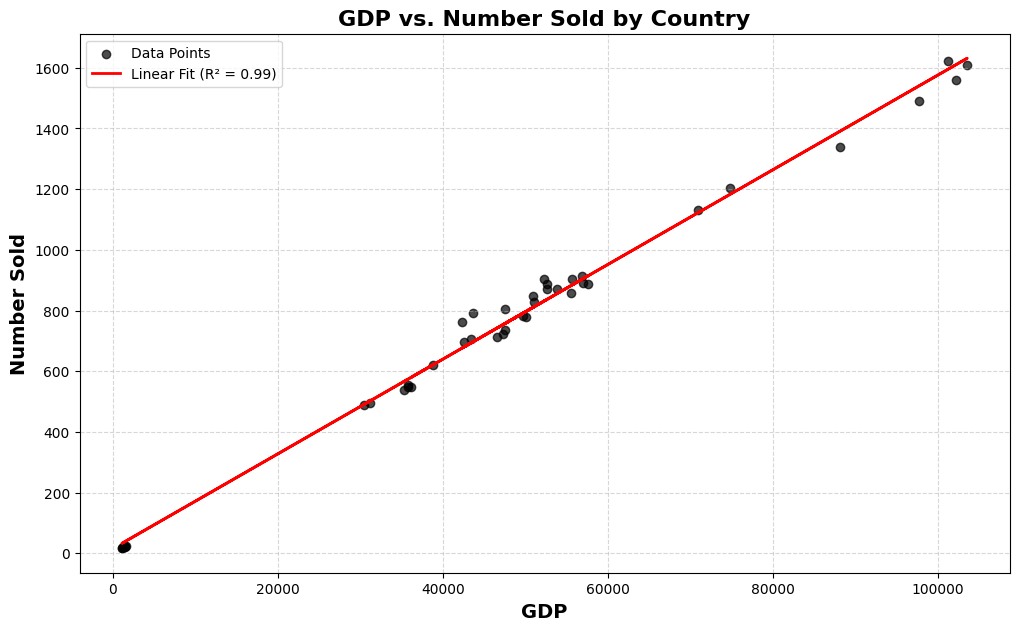

In [37]:
# Plot (ignore code)
x_values = []
y_values = []

for country in config.countries:
    if country in num_sold_by_ctry_year["country"].values and country in gdp_df.index:
        gdp_values = gdp_df.loc[country, config.train_years].values
        sales_values = num_sold_by_ctry_year[
            num_sold_by_ctry_year["country"] == country
        ]["num_sold_by_ctry_year"].values

        x_values.extend(gdp_values)
        y_values.extend(sales_values)

# Convert to numpy arrays
x_values = np.array(x_values)
y_values = np.array(y_values)

# Fit a linear regression model
x_with_intercept = sm.add_constant(x_values)  # Add intercept term for regression
model = sm.OLS(y_values, x_with_intercept).fit()
y_pred = model.predict(x_with_intercept)
r_squared = model.rsquared

# Plot
plt.figure(figsize=(12, 7))
plt.scatter(x_values, y_values, color="black", alpha=0.7, label="Data Points")
plt.plot(
    x_values,
    y_pred,
    color="red",
    linewidth=2,
    label=f"Linear Fit (R² = {r_squared:.2f})",
)
plt.xlabel("GDP", fontsize=14, fontweight="bold")
plt.ylabel("Number Sold", fontsize=14, fontweight="bold")
plt.title("GDP vs. Number Sold by Country", fontsize=16, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

The plot above shows a simple linear regression between gdp annual figures and total sales by year. The country factor is not taken here into account as it will be represented in another factor.

In [38]:
# Create gdp_factor in the main DataFrame. The gdp factor is simply the gdp for that country (year, pair):
df["gdp_factor"] = None

for year in config.years:
    for country in config.countries:
        df.loc[(df.country == country) & (df.year == year), "gdp_factor"] = gdp_df.at[
            country, year
        ]
        
df.head()

,id,date,country,store,product,num_sold,test,year,weekday,day_of_year,...,cos_24pi,sin_8pi,cos_8pi,sin_6pi,cos_6pi,sin_4pi,cos_4pi,sin_pi,cos_pi,gdp_factor
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,0,2010,4,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,47560.666601
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,0,2010,4,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,47560.666601
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,0,2010,4,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,47560.666601
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,0,2010,4,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,47560.666601
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,0,2010,4,1,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,47560.666601


### Store Factor

Instead of hot encoding the store names with dummy variables like `0, 1, 2, 3..`, a store factor is created by averaging the total `num_sold` per store, which provides meaningful order relationship between stores. Canada and Kenya are excluded of the analysis because of missing values (see *Notebook 1*)

In [39]:
df_no_can_ken = df[~df.country.isin(("Canada", "Kenya"))]
store_df = (
    df_no_can_ken.groupby(by="store").num_sold.mean().rename("store_factor").to_frame()
)
df = df.join(store_df, on="store", how="left")
store_df

,store_factor
store,
Discount Stickers,495.493880
Premium Sticker Mart,1184.224736
Stickers for Less,1002.354517


## Product Factor

Similarly, we define the **product factor** of the $i$-th product at day $j$ as the proportion of the sales coming from product $i$ at day $j$:

$$
\text{Product Factor}_{i,j} = \frac{\text{Sales of Product } i \text{ on Day } j}{\sum_{k} \text{Sales of Product } k \text{ on Day } j}
$$

For the test set, directly computing this ratio would lead to data leakage, as it depends on the target variable. Instead, we estimate it using a **regression model on seasonal features**:

$$
\hat{\text{Product Factor}}_{i,j} = f(\mathbf{x}_{i,j})
$$

where:
- $\mathbf{x}_{i,j}$ represents the seasonal features (e.g., sine/cosine time encodings).
- $f(\cdot)$ is a fitted model (e.g., Ridge regression) mapping seasonal features to an estimated product factor.

For hour Hypothesis set, we choose the set of ridge regressors as our only training data until now are  seasonal features which are highly collinear. Ridge regression adds an $L2$ regularization term to the loss function that penalises large coefficients. 


In [40]:
# ratio of sales per tuple (country, strore, product) / total sales per day
df_no_can_ken = df[~df.country.isin(("Canada", "Kenya"))].copy()
total = df_no_can_ken.groupby(by="date").num_sold.sum().rename("num_sold_total_day")
df_no_can_ken = df_no_can_ken.join(total, on="date", how="left")
df_no_can_ken["num_sold_ratio"] = (
    df_no_can_ken["num_sold"] / df_no_can_ken["num_sold_total_day"]
)
df_no_can_ken.loc[:, ["date", "num_sold_total_day", "num_sold_ratio"]].head(10)

,date,num_sold_total_day,num_sold_ratio
15,2010-01-01,70174.0,0.002138
16,2010-01-01,70174.0,0.013196
17,2010-01-01,70174.0,0.011030
18,2010-01-01,70174.0,0.006042
19,2010-01-01,70174.0,0.006413
20,2010-01-01,70174.0,0.004432
21,2010-01-01,70174.0,0.027760
22,2010-01-01,70174.0,0.023256
23,2010-01-01,70174.0,0.012512
24,2010-01-01,70174.0,0.013538


R^2 for Holographic Goose is 0.9385621611213433
R^2 for Kaggle is 0.5815762622620828
R^2 for Kaggle Tiers is 0.7041329658627206
R^2 for Kerneler is 0.9578456404892868
R^2 for Kerneler Dark Mode is 0.9706852503927457


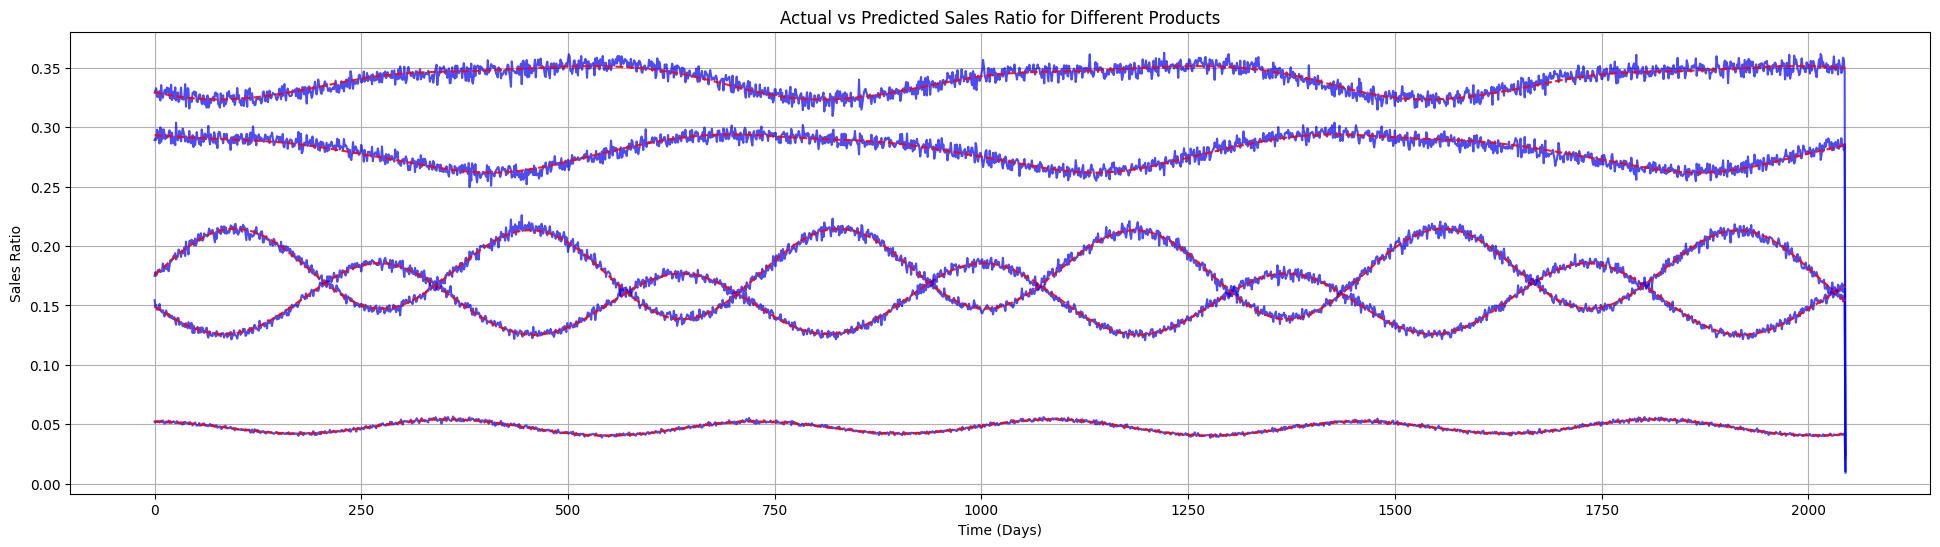

In [41]:
plt.figure(figsize=(24, 6))
df["product_factor"] = None  # Initialize product factor column

for product in config.products:
    # Filter data for the current product and group by date
    df_no_can_ken_date = df_no_can_ken[
        (df_no_can_ken["product"] == product) & (df_no_can_ken["test"] == 0)
    ].groupby(by="date")
    x = df_no_can_ken_date[config.sincoscol + config.sincoscol2].mean().to_numpy()
    y = df_no_can_ken_date.num_sold_ratio.sum().to_numpy()

    # Fit Ridge regression to capture seasonal effects
    reg = Ridge()
    reg.fit(x, y)
    p = reg.predict(x)

    # Store predicted seasonal component
    df.loc[(df["product"] == product), "product_factor"] = reg.predict(
        df.loc[
            (df["product"] == product), config.sincoscol + config.sincoscol2
        ].to_numpy()
    )

    print(f"R^2 for {product} is {reg.score(x, y)}")

    # Plot actual vs predicted sales ratio
    plt.plot(y, "b", linestyle="-", alpha=0.7)
    plt.plot(p, "r", linestyle="--", alpha=0.9)

plt.title("Actual vs Predicted Sales Ratio for Different Products")
plt.xlabel("Time (Days)")
plt.ylabel("Sales Ratio")
plt.grid(True)
plt.show()

### Weekday Factor

It is also intuitive weekends will also have higher sales than other normal day. To analyse the `weekday_factor` we need to exclude of the analysis the holidays of for every country as they could alter the study. For this we can make use of the `holidays` libary.

In [42]:
# Encode with 1 days that are
df["holiday"] = 0

for country in config.countries:
    days = [
        str(day)
        for day in holidays.CountryHoliday(
            config.countries_2l[country], years=config.years
        )
    ]
    df.loc[(df.country == country) & (df.date.isin(days)), "holiday"] = 1

We show the ratio of sales per day every week in each country.

In [43]:
# Calculate the percentage of sales per day for all weeks in each country.
num_sold_per_week_country_weekday = (
    df.groupby(["week_num", "country", "weekday"])["num_sold"]
    .sum()
    .reset_index()
    .pivot(index=["week_num", "country"], columns="weekday")
)
ratio_sold_per_week_country_weekday = num_sold_per_week_country_weekday.apply(
    lambda row: row / sum(row), axis=1
).reset_index()
ratio_sold_per_week_country_weekday.head(10)

week_num    country  num_sold                                          \
weekday                             0         1         2         3         4   
0              0     Canada  0.129974  0.126479  0.123961  0.118794  0.165989   
1              0    Finland  0.131095  0.128887  0.124054  0.119056  0.168715   
2              0      Italy  0.130714  0.131071  0.124982  0.119422  0.166448   
3              0      Kenya  0.132799  0.129365  0.119634  0.113337  0.167716   
4              0     Norway  0.134553  0.126959  0.122035  0.119080  0.165032   
5              0  Singapore  0.131792  0.125545  0.124798  0.119180  0.165048   
6              1     Canada  0.135548  0.132407  0.130246  0.133347  0.148607   
7              1    Finland  0.134360  0.134450  0.126876  0.129542  0.147704   
8              1      Italy  0.132590  0.134025  0.133646  0.129522  0.148541   
9              1      Kenya  0.133891  0.133891  0.125523  0.133891  0.149233   

                             
weekday         5         6  
0        0.163152  0.171650  
1        0.157643  0.170550  
2        0.155627  0.171736  
3        0.163709  0.173440  
4        0.160629  0.171711  
5        0.162418  0.171219  
6        0.153319  0.166526  
7        0.154170  0.172899  
8        0.154017  0.167659  
9        0.153417  0.170153

In [44]:
ratio_weekday = pd.DataFrame(
    columns=config.countries,
    data=[
        [
            0,
        ]
        * len(config.countries)
    ]
    * 7,
)


The median proportion per weekday is then computed for each country, mitigating the influence of extreme values. To generalize the weekday effect across all countries, an overall mean weekday factor is obtained by averaging across countries. This factor is then mapped to each observation in the dataset based on its weekday, providing a stable adjustment for cyclical sales patterns. The approach assumes that weekday-driven sales variations are persistent and that historical patterns are predictive of future distributions.

In [45]:
# Take median for every weak in each week day vector
for n, country in enumerate(config.countries):
    for day in range(7):
        dt = ratio_sold_per_week_country_weekday.loc[
            ratio_sold_per_week_country_weekday.country == country, ("num_sold", day)
        ][:-60]
        ratio_weekday.loc[day, country] = dt.median()

ratio_weekday["mean"] = ratio_weekday.mean(axis=1)
df["weekday_factor"] = df.weekday.map(ratio_weekday["mean"])

# The total ratio taking into account all factors
df["ratio"] = (
    df["gdp_factor"] * df["product_factor"] * df["store_factor"] * df["weekday_factor"]
)

# The total sold items taking into account all factors
df["total"] = df["num_sold"] / df["ratio"]

In [46]:
ratio_weekday

,Canada,Finland,Italy,Kenya,Norway,Singapore,mean
0,0.134204,0.134586,0.134465,0.134067,0.134881,0.134686,0.134482
1,0.134319,0.134748,0.134866,0.133872,0.134877,0.134576,0.134543
2,0.134086,0.134528,0.134643,0.133904,0.134920,0.134737,0.134470
3,0.133987,0.134792,0.134667,0.133976,0.134709,0.134632,0.134461
4,0.143165,0.142900,0.142772,0.143057,0.142665,0.142914,0.142912
5,0.151503,0.150715,0.151021,0.151744,0.150691,0.150872,0.151091
6,0.168339,0.166963,0.166865,0.169451,0.167141,0.166989,0.167625


### Holiday effect and Day of year Factor

In [47]:
# Holiday response hold the days affected by holidays.
# The response time could be caused by shipping times and other human factors
# Some notebooks in the competition have considered more sophisticated ways
# to capture the holidays response (TO DO). We arbitarily choose in the config 5 days.
df_holidays = df.copy()
df_holidays["holiday_response"] = 0

# Step 2: Mark holiday-affected days (holidays + response period)
for country in config.countries:
    country_code = config.countries_2l[country]  # Get country code
    holiday_dates = holidays.CountryHoliday(country_code, years=config.years).items()

    for holiday, _ in holiday_dates:
        response_period = pd.date_range(holiday, periods=config.holiday_response_len)

        df_holidays.loc[
            (df_holidays.country == country) & (df_holidays.date.isin(response_period)),
            "holiday_response",
        ] = 1

The holidays treatment need much more care. For example we may find difficulties in modelling the week between Christmas and New year as some competition notebooks argue the data also exhibits pre-holiday effects. During this period the pre holiday effect of New Year and the post holiday effect of Christmas overlap. 

Moreover, some other notebooks have shown that the `holidays` library is not perfect and misses some holidays or names them incorrectly for Kenya.

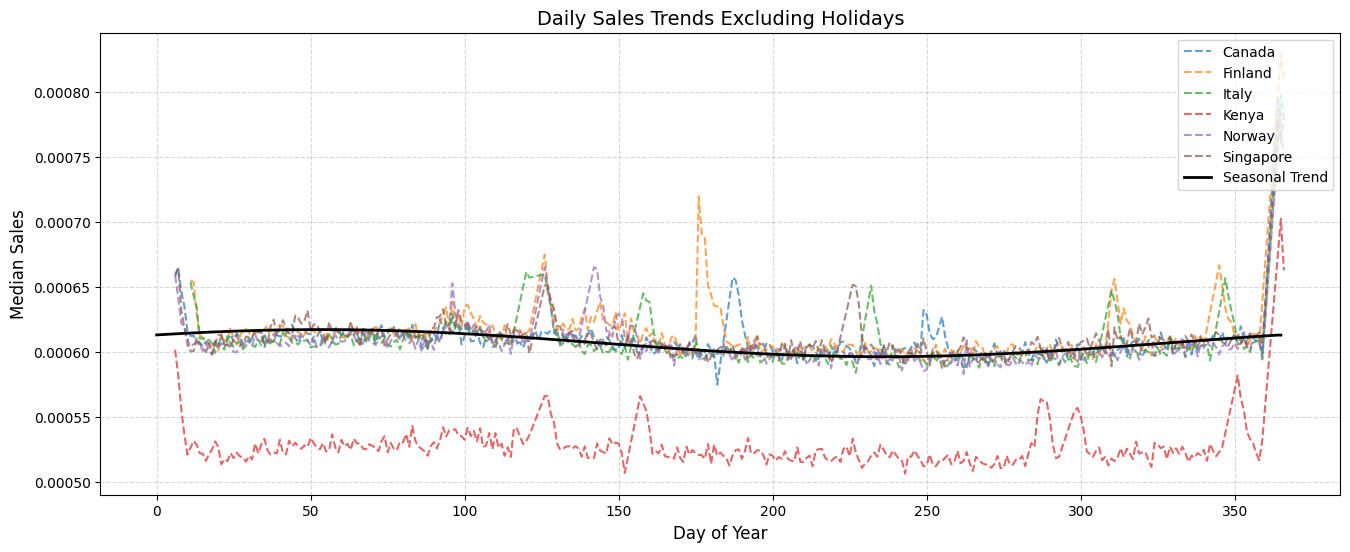

In [48]:
# Step 3: Compute the median sales trend per country, excluding holidays
fig, ax = plt.subplots(figsize=(16, 6))
data = pd.DataFrame()

for n, country in enumerate(config.countries):
    dt = (
        df_holidays[
            (df_holidays.country == country) & (df_holidays.holiday_response == 0)
        ]
        .groupby(["day_of_year"])
        .total.median()
    )
    data[country] = dt
    ax.plot(
        dt, label=country, linestyle="--", alpha=0.7
    )  # Use dashed lines for clarity

# Compute the overall median trend across all countries
data["median"] = data.median(axis=1)

# Step 4: Fit a Fourier-based Ridge regression model to capture seasonality
x = data.index.to_numpy()
y = data["median"].to_numpy()

fourier = lambda t: np.array([np.sin(2 * np.pi / 365 * t), np.cos(2 * np.pi / 365 * t)])
year_ratio = (
    Ridge(alpha=0.01).fit(fourier(x).T, y.T).predict(fourier(np.arange(1, 366)).T)
)
year_ratio = np.append(year_ratio, year_ratio[-1])  # Extend to full year

# Step 5: Apply the computed seasonal factor to the main dataframe
df["day_of_year_factor"] = df.day_of_year.map(dict(zip(np.arange(1, 367), year_ratio)))

# Step 6: Compute the final sales adjustment ratio
df["ratio"] = (
    df["gdp_factor"]
    * df["product_factor"]
    * df["store_factor"]
    * df["weekday_factor"]
    * df["day_of_year_factor"]
)

# Step 7: Compute the adjusted total sales
df["total"] = df["num_sold"] / df["ratio"]

# Step 8: Plot
ax.plot(
    year_ratio, "k", linewidth=2, label="Seasonal Trend"
)  # Black line for main trend
ax.legend(loc="upper right", fontsize=10)  # Move legend for better readability
ax.set_title("Daily Sales Trends Excluding Holidays", fontsize=14)
ax.set_xlabel("Day of Year", fontsize=12)
ax.set_ylabel("Median Sales", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.5)  # Subtle grid for better readability
plt.show()

### The sincos dependence on the day of year

Moreover, we can see a periodic dependence on the longer time periods. We can take this into account, too, by incorporating more fourier members.

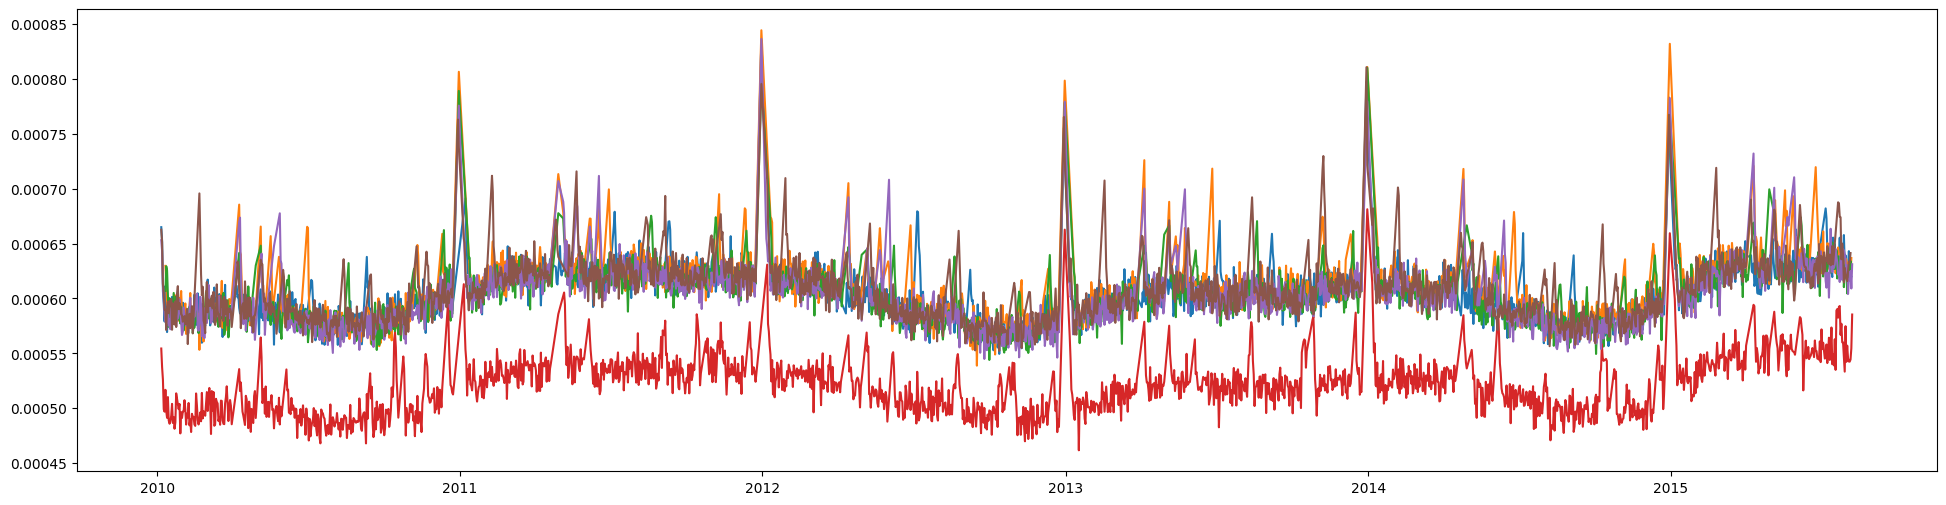

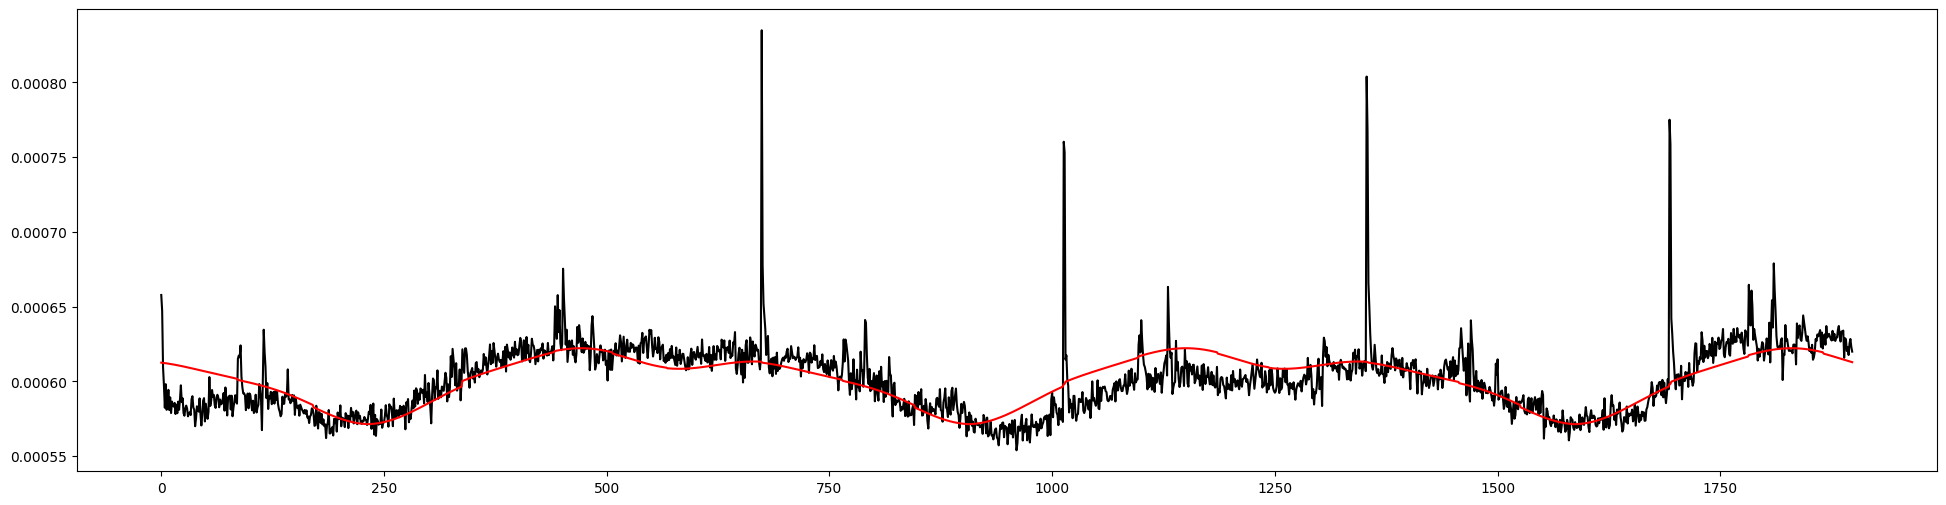

In [49]:
fig = plt.figure(figsize=(24, 6))
data = pd.DataFrame()
for n, country in enumerate(config.countries):
    dt = (
        df_holidays[
            (df_holidays.test == 0)
            & (df_holidays.country == country)
            & (df_holidays.holiday_response == 0)
        ]
        .groupby(["date"])
        .total.median()
    )
    data[country] = dt
    plt.plot(dt, label=country)
data["median"] = data.median(axis=1)

# Linear regression on fourier series
dfsc = df[df.test == 0].groupby("date")[config.sincoscol2].mean()  # .to_numpy()
dfsc["median"] = data["median"]

x = dfsc[~pd.isna(dfsc["median"])][config.sincoscol2].to_numpy()
y = dfsc[~pd.isna(dfsc["median"])]["median"].to_numpy()

reg = Ridge(alpha=0.01, fit_intercept=True)
reg.fit(x, y)

fig = plt.figure(figsize=(24, 6))
plt.plot(y, "k")
plt.plot(reg.predict(x), "r")

df["sincos_factor"] = reg.intercept_ + (df[config.sincoscol2] * reg.coef_).sum(axis=1)

### Country Factor

This one is pretty descriptive. Even though GDP already characterises the country, there might be some intrinsic behaviours to every country, therefore we create a `country_factor` by marking it with its total sales per year 

In [50]:
country_factor = (
    df[(df["product"] == "Kaggle")]
    .groupby("country")
    .total.sum()
    .rename("country_factor")
)
country_factor = country_factor / country_factor.median()
df = df.join(country_factor, on="country", how="left")

In [51]:
cya_factor = df.groupby(["country", "day_of_year"]).total.mean().rename("cya_factor")
df = df.join(cya_factor, on=["country", "day_of_year"], how="left")

We now store the `transformed_features.csv` to use it in the next notebook.

In [ ]:
# df.to_csv("transformed_features.csv")